In [ ]:
import pandas as pd
from pathlib import Path
import optuna
import numpy as np
import plotly.express as px
import re
# import optuna

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
from pathlib import Path
from pandas.api.types import is_numeric_dtype

import plotly.graph_objs as go

In [ ]:
df = pd.read_csv('../data/data.csv')

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df = df.set_index('timestamp')

In [ ]:
df = df.resample('60min').mean()

In [ ]:
df = df.reset_index()
end_date = '2014-06-20 00:00:00'
mask = (df.timestamp <= end_date)
mask2 = (df.timestamp >= '2014-05-31 00:00:00')
df_temp = df.loc[mask]
df_temp = df_temp.reset_index()
df_temp = df_temp.loc[mask2]
df_temp

,index,timestamp,value
407,407,2014-05-31 00:00:00,35.452250
408,408,2014-05-31 01:00:00,35.955000
409,409,2014-05-31 02:00:00,36.084750
410,410,2014-05-31 03:00:00,37.243167
411,411,2014-05-31 04:00:00,36.480917
...,...,...,...
883,883,2014-06-19 20:00:00,34.491417
884,884,2014-06-19 21:00:00,34.209667
885,885,2014-06-19 22:00:00,36.815667
886,886,2014-06-19 23:00:00,36.457917


In [ ]:
df = df.reset_index()
df

,timestamp,value
0,2014-05-14 01:00:00,49.703600
1,2014-05-14 02:00:00,38.210083
2,2014-05-14 03:00:00,40.346917
3,2014-05-14 04:00:00,35.579833
4,2014-05-14 05:00:00,32.913333
...,...,...
1500,2014-07-15 13:00:00,13.603500
1501,2014-07-15 14:00:00,13.587250
1502,2014-07-15 15:00:00,13.580917
1503,2014-07-15 16:00:00,13.638167


In [ ]:
def train_baseline_prophet_model(df_red):
    # df_red = df_red[['timestamp', 'value']]
    # df_red.columns = ['ds', 'y']
    m = Prophet()
    m.fit(df_red)
    return m

In [ ]:
df.columns = ['ds', 'y']

In [ ]:
end_date = '2014-06-25 00:00:00'
mask = (df['ds'] <= end_date)
df_train = df.loc[mask]
df_test = df.loc[~mask]

In [ ]:
df_train = df_train.reset_index()

In [ ]:
df_test = df_test.reset_index()
df_test

,index,ds,y
0,1008,2014-06-25 01:00:00,36.715417
1,1009,2014-06-25 02:00:00,35.994750
2,1010,2014-06-25 03:00:00,37.360083
3,1011,2014-06-25 04:00:00,36.540833
4,1012,2014-06-25 05:00:00,36.586667
...,...,...,...
492,1500,2014-07-15 13:00:00,13.603500
493,1501,2014-07-15 14:00:00,13.587250
494,1502,2014-07-15 15:00:00,13.580917
495,1503,2014-07-15 16:00:00,13.638167


In [ ]:
m = train_baseline_prophet_model(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
preds = m.predict(df_test)

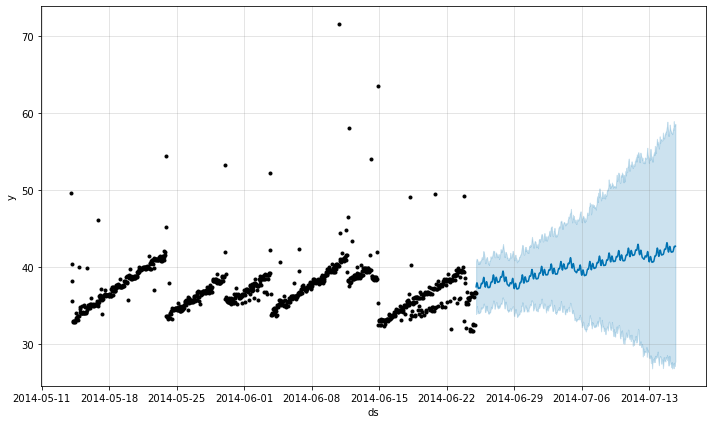

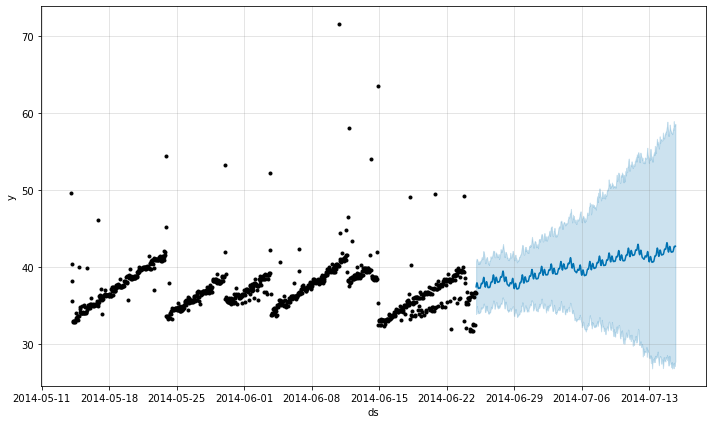

In [ ]:
m.plot(preds)

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], name='Actual',))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], name='Training Actuals',))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat_lower'], name='yhat_lower', fill='tozeroy', mode='lines'))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat_upper'], name='yhat_upper',fill='tozeroy', mode='lines'))
fig.update_layout(
    title=f"model prediction vs actual",
    xaxis_title="Timestamps",
    yaxis_title=f"value",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    ))
# fig.write_html(f"/content/plots/{name}-{metric}.html")
fig.show()

In [ ]:
df_cv = cross_validation(m, horizon='5day')
df_p = performance_metrics(df_cv, rolling_window=1)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2014-05-31 00:00:00 and 2014-06-20 00:00:00


In [ ]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,5 days,32.053026,5.661539,4.481786,0.120496,0.096578,0.336111


In [ ]:
def prophet_objective(trial, df_past, horizon):
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ["additive", "multiplicative"]) #
    changepoint_prior_scale = trial.suggest_uniform('changepoint_prior_scale', 0.001,0.5)
    changepoint_range = trial.suggest_float('changepoint_range', 0.50,0.85)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01,10, log=True)#
    growth = trial.suggest_categorical('growth', ["linear", "flat"])

    m = Prophet(
        growth=growth,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
#         holidays=holidays_subset,
        uncertainty_samples=0
    )

    m.fit(df_past)

    #Using INITIAL days to train, build a forecast of HORIZON days long, every PERIOD days
    df_cv = cross_validation(m, horizon=horizon)
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p)
    mape = np.mean(df_p.mape)
    return mape

In [ ]:
df_cv = cross_validation(m, horizon='5day')
df_p = performance_metrics(df_cv, rolling_window=1)

In [ ]:
df_p

In [ ]:
def train_optimal_prophet_model(df: pd.DataFrame):
    study = optuna.create_study(direction='minimize')
#     initial, period, horizon = get_iph(df)
#     df = df[['timestamp', 'value']]
#     df.columns = ['ds', 'y']
    study.optimize(
        lambda trial: prophet_objective(
            trial, df, '10day'
        ),
        n_trials=30
    )

    return study.best_params

In [ ]:
best_params = train_optimal_prophet_model(df_train)
best_params

[I 2020-11-30 11:40:36,156] A new study created in memory with name: no-name-e403633b-f02b-402d-8db3-bba50788b977
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:38,035] Trial 0 finished with value: 0.2443366275843051 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2032217997146649, 'changepoint_range': 0.6714355485438968, 'seasonality_prior_scale': 0.3227401157619449, 'growth': 'linear'}. Best is trial 0 with value: 0.2443366275843051.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  79.755749  8.930607  8.615182  0.244337  0.248525


[I 2020-11-30 11:40:38,291] Trial 1 finished with value: 0.07994060663268593 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.3599623444393691, 'changepoint_range': 0.6910636242462468, 'seasonality_prior_scale': 0.06699895720478741, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.828321  3.290641  2.815888  0.079941  0.073776


[I 2020-11-30 11:40:38,531] Trial 2 finished with value: 0.07994870607669925 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.3071165781932143, 'changepoint_range': 0.6071548855949923, 'seasonality_prior_scale': 4.062385375126792, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.830149  3.290919  2.816187  0.079949  0.073814


[I 2020-11-30 11:40:38,788] Trial 3 finished with value: 0.07994871016708355 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.34475070463521296, 'changepoint_range': 0.8452942171582971, 'seasonality_prior_scale': 5.971446577402854, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon       mse      rmse       mae      mape     mdape
0 10 days  10.83015  3.290919  2.816187  0.079949  0.073814


[I 2020-11-30 11:40:39,093] Trial 4 finished with value: 0.07994875131214735 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06836094021598718, 'changepoint_range': 0.5846072012197749, 'seasonality_prior_scale': 4.728954428092104, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.830198  3.290927  2.816188  0.079949  0.073815


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:41,103] Trial 5 finished with value: 0.21459467324157525 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1649318679402423, 'changepoint_range': 0.6170133793472861, 'seasonality_prior_scale': 0.04100216056913912, 'growth': 'linear'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  61.642404  7.851268  7.554668  0.214595  0.225741


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:42,278] Trial 6 finished with value: 0.21361042389705073 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03843997613278116, 'changepoint_range': 0.6964672835746333, 'seasonality_prior_scale': 0.015312202321527704, 'growth': 'linear'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae     mape     mdape
0 10 days  61.244626  7.825895  7.520675  0.21361  0.219657


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:46,442] Trial 7 finished with value: 0.24619555965829173 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2634724050607438, 'changepoint_range': 0.7025982990952625, 'seasonality_prior_scale': 0.6246982961580636, 'growth': 'linear'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  81.096451  9.005357  8.680775  0.246196  0.249211


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:51,430] Trial 8 finished with value: 0.23764239643471619 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.3774739603853922, 'changepoint_range': 0.6351645941603643, 'seasonality_prior_scale': 1.0249120372719092, 'growth': 'linear'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  76.156545  8.726772  8.371986  0.237642  0.238585


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:51,893] Trial 9 finished with value: 0.07994874973293396 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.46055925097686823, 'changepoint_range': 0.5313933418226389, 'seasonality_prior_scale': 3.3736900972159494, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.830198  3.290927  2.816188  0.079949  0.073815


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:52,421] Trial 10 finished with value: 0.07994143911374779 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4602440923673936, 'changepoint_range': 0.7870484829098805, 'seasonality_prior_scale': 0.07071249738718244, 'growth': 'flat'}. Best is trial 1 with value: 0.07994060663268593.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape    mdape
0 10 days  10.828513  3.290671  2.815918  0.079941  0.07378


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:52,947] Trial 11 finished with value: 0.07993996620557337 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4909312684057037, 'changepoint_range': 0.784843271377102, 'seasonality_prior_scale': 0.06450884112936277, 'growth': 'flat'}. Best is trial 11 with value: 0.07993996620557337.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae     mape     mdape
0 10 days  10.828174  3.290619  2.815864  0.07994  0.073772


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:53,560] Trial 12 finished with value: 0.07994414994310378 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.49394868203703735, 'changepoint_range': 0.7714549481381825, 'seasonality_prior_scale': 0.08914835319500235, 'growth': 'flat'}. Best is trial 11 with value: 0.07993996620557337.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.829138  3.290766  2.816018  0.079944  0.073793


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:54,038] Trial 13 finished with value: 0.07972962858224886 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.39451988064850907, 'changepoint_range': 0.7661653090771537, 'seasonality_prior_scale': 0.012750090352630994, 'growth': 'flat'}. Best is trial 13 with value: 0.07972962858224886.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae     mape     mdape
0 10 days  10.780252  3.283329  2.808108  0.07973  0.072756


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:54,534] Trial 14 finished with value: 0.07969860918942005 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4139847069106448, 'changepoint_range': 0.7718697194568793, 'seasonality_prior_scale': 0.01190749439858542, 'growth': 'flat'}. Best is trial 14 with value: 0.07969860918942005.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.773272  3.282266  2.806965  0.079699  0.072653


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:55,027] Trial 15 finished with value: 0.07960130633570683 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.39323016283581425, 'changepoint_range': 0.845285743484694, 'seasonality_prior_scale': 0.010032572819874512, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.751528  3.278952  2.803376  0.079601  0.072514


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:55,545] Trial 16 finished with value: 0.07988708309262023 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4221817769745652, 'changepoint_range': 0.84650919138222, 'seasonality_prior_scale': 0.024276688970661223, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.816026  3.288773  2.813914  0.079887  0.073517


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:56,067] Trial 17 finished with value: 0.07963907607313958 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.3023240526045139, 'changepoint_range': 0.837238567099128, 'seasonality_prior_scale': 0.01065618809533872, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.759942  3.280235  2.804769  0.079639  0.072568


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:56,538] Trial 18 finished with value: 0.07989140932075484 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2779161720131174, 'changepoint_range': 0.8210155416992682, 'seasonality_prior_scale': 0.02518215122071009, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.817018  3.288923  2.814074  0.079891  0.073538


[I 2020-11-30 11:40:57,062] Trial 19 finished with value: 0.07994743282166779 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.20034466895334618, 'changepoint_range': 0.7403341114645872, 'seasonality_prior_scale': 0.16649651012057043, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.829894  3.290881  2.816139  0.079947  0.073809


[I 2020-11-30 11:40:57,627] Trial 20 finished with value: 0.0796103708161007 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.10891095924245223, 'changepoint_range': 0.8211461622059556, 'seasonality_prior_scale': 0.010172824937176389, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.



  horizon        mse     rmse       mae     mape     mdape
0 10 days  10.753544  3.27926  2.803711  0.07961  0.072527


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:58,252] Trial 21 finished with value: 0.0797190184029774 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.11084024904969611, 'changepoint_range': 0.8186642152855028, 'seasonality_prior_scale': 0.012443002921869823, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.777862  3.282965  2.807717  0.079719  0.072704


[I 2020-11-30 11:40:58,826] Trial 22 finished with value: 0.07989688980822096 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.29573825245578395, 'changepoint_range': 0.8191223302977857, 'seasonality_prior_scale': 0.026487684529195137, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.818274  3.289114  2.814276  0.079897  0.073564


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:59,424] Trial 23 finished with value: 0.07985616527511405 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.325600881341207, 'changepoint_range': 0.8397583718491094, 'seasonality_prior_scale': 0.01977660065623083, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.808956  3.287698  2.812774  0.079856  0.073367


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:40:59,975] Trial 24 finished with value: 0.07961702526390171 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2115712325863539, 'changepoint_range': 0.744972425803504, 'seasonality_prior_scale': 0.0102793625127529, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.755026  3.279486  2.803956  0.079617  0.072537


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:41:00,442] Trial 25 finished with value: 0.0799188088678141 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.13439376636929115, 'changepoint_range': 0.7355205068269395, 'seasonality_prior_scale': 0.03490296724302617, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape    mdape
0 10 days  10.823306  3.289879  2.815084  0.079919  0.07367


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:41:00,948] Trial 26 finished with value: 0.07961032845934903 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.20487715939707712, 'changepoint_range': 0.7996460730484088, 'seasonality_prior_scale': 0.010172156773026887, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00



  horizon        mse      rmse       mae     mape     mdape
0 10 days  10.753535  3.279258  2.803709  0.07961  0.072527


[I 2020-11-30 11:41:01,438] Trial 27 finished with value: 0.0799462146195652 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.0015305564445707853, 'changepoint_range': 0.8049924988195386, 'seasonality_prior_scale': 0.12006316031724255, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  10.829614  3.290838  2.816095  0.079946  0.073803


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:41:02,001] Trial 28 finished with value: 0.07993142826021873 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.09365079545798825, 'changepoint_range': 0.7984756148242271, 'seasonality_prior_scale': 0.04591912618952429, 'growth': 'flat'}. Best is trial 15 with value: 0.07960130633570683.



  horizon        mse     rmse       mae      mape     mdape
0 10 days  10.826208  3.29032  2.815549  0.079931  0.073731


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


[I 2020-11-30 11:41:05,675] Trial 29 finished with value: 0.23589659153445838 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.21070094626661307, 'changepoint_range': 0.7187252584665472, 'seasonality_prior_scale': 0.19617094132595964, 'growth': 'linear'}. Best is trial 15 with value: 0.07960130633570683.



  horizon        mse      rmse       mae      mape     mdape
0 10 days  74.140009  8.610459  8.315116  0.235897  0.242905


{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.39323016283581425,
 'changepoint_range': 0.845285743484694,
 'seasonality_prior_scale': 0.010032572819874512,
 'growth': 'flat'}

In [ ]:
m = Prophet(
    growth=best_params['growth'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

In [ ]:
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
m = Prophet()

In [ ]:
preds = m.predict(df_test)

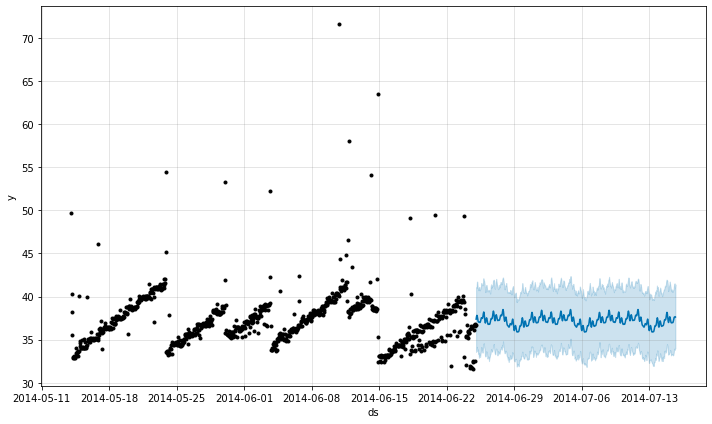

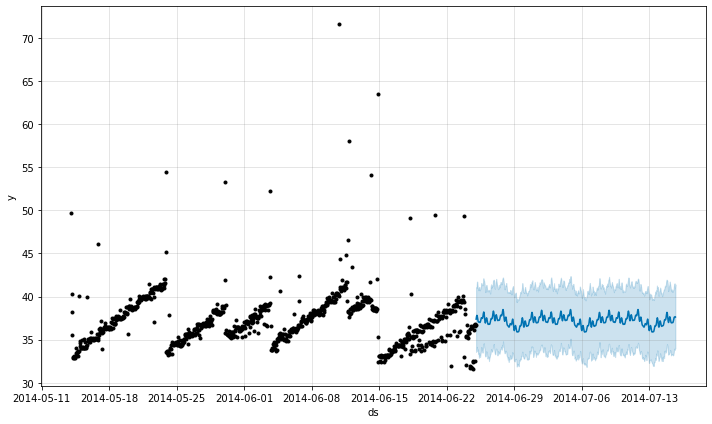

In [ ]:
m.plot(preds)

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], name='Actual',))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], name='Training Actuals',))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat_lower'], name='yhat_lower', fill='tozeroy', mode='lines'))
fig.add_trace(go.Scatter(x=preds['ds'], y=preds['yhat_upper'], name='yhat_upper',fill='tozeroy', mode='lines'))
fig.update_layout(
    title=f"model prediction vs actual",
    xaxis_title="Timestamps",
    yaxis_title=f"value",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    ))
fig.show()

In [ ]:
df_cv = cross_validation(m, horizon='5day')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2014-05-31 00:00:00 and 2014-06-20 00:00:00


In [ ]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,coverage
count,109,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,2 days 18:00:00,12.899792,3.526038,2.557128,0.067044,0.056082,0.806745
std,1 days 07:36:34.551714921,4.758930,0.686419,0.266462,0.005587,0.004691,0.068542
min,0 days 12:00:00,4.908903,2.215604,1.922793,0.053728,0.043146,0.657407
25%,1 days 15:00:00,9.623297,3.102144,2.402965,0.063404,0.052621,0.759259
50%,2 days 18:00:00,12.635485,3.554643,2.624947,0.067677,0.054766,0.805556
75%,3 days 21:00:00,15.741432,3.967547,2.741413,0.071118,0.059861,0.861111
max,5 days 00:00:00,20.980343,4.580430,2.966051,0.077220,0.065178,0.925926


In [ ]:
df_p.mse.mean()

12.899791602895565

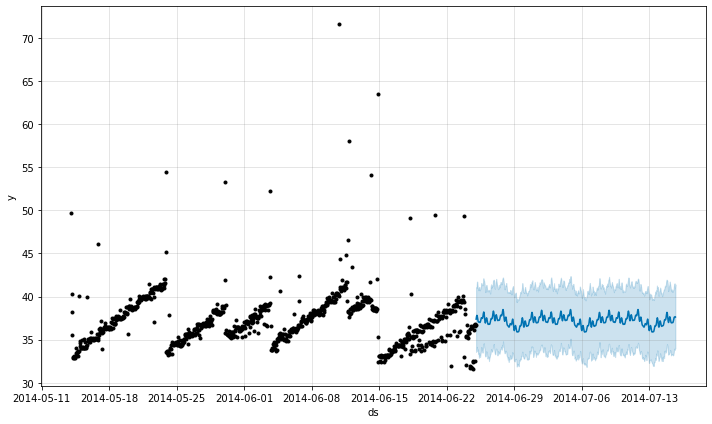

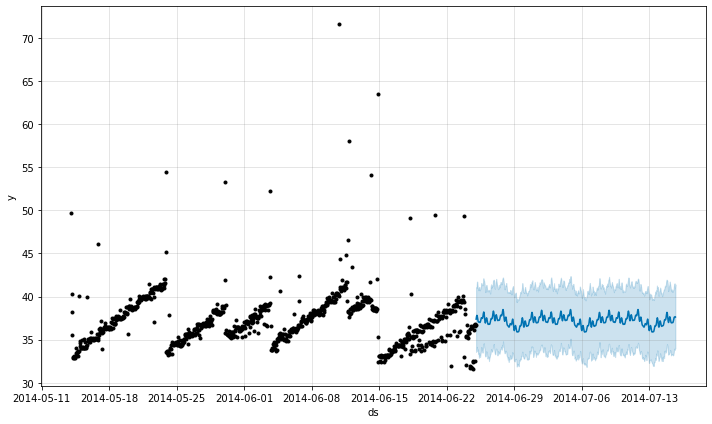

In [ ]:
m.plot(preds)

In [ ]:
df_temp = df_temp.drop(columns='index')

In [ ]:
df_temp.columns=['ds, y']

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [ ]:
df_temp

,timestamp,value
407,2014-05-31 00:00:00,35.452250
408,2014-05-31 01:00:00,35.955000
409,2014-05-31 02:00:00,36.084750
410,2014-05-31 03:00:00,37.243167
411,2014-05-31 04:00:00,36.480917
...,...,...
883,2014-06-19 20:00:00,34.491417
884,2014-06-19 21:00:00,34.209667
885,2014-06-19 22:00:00,36.815667
886,2014-06-19 23:00:00,36.457917


In [ ]:
preds2 = m.predict(df_temp)

KeyError: 'ds'

In [ ]:
df_cv2 = cross_validation(m, horizon='10day')
df_p2 = performance_metrics(df_cv)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-06-15 00:00:00 and 2014-06-15 00:00:00


In [ ]:
df_p2

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 12:00:00,4.908903,2.215604,1.922793,0.053728,0.043146,0.907407
1,0 days 13:00:00,5.025870,2.241845,1.955081,0.054601,0.045950,0.907407
2,0 days 14:00:00,5.034533,2.243776,1.959488,0.054663,0.049010,0.916667
3,0 days 15:00:00,5.014228,2.239247,1.973987,0.054936,0.050187,0.925926
4,0 days 16:00:00,5.080662,2.254032,1.981685,0.055108,0.050423,0.925926
...,...,...,...,...,...,...,...
104,4 days 20:00:00,18.977474,4.356314,2.884424,0.075170,0.054072,0.768519
105,4 days 21:00:00,14.647070,3.827149,2.673551,0.071147,0.053476,0.787037
106,4 days 22:00:00,14.517704,3.810211,2.671589,0.071093,0.053249,0.777778
107,4 days 23:00:00,14.846435,3.853107,2.735243,0.073067,0.053377,0.759259


In [ ]:
df_p2.mape.mean()

0.06704384249037611

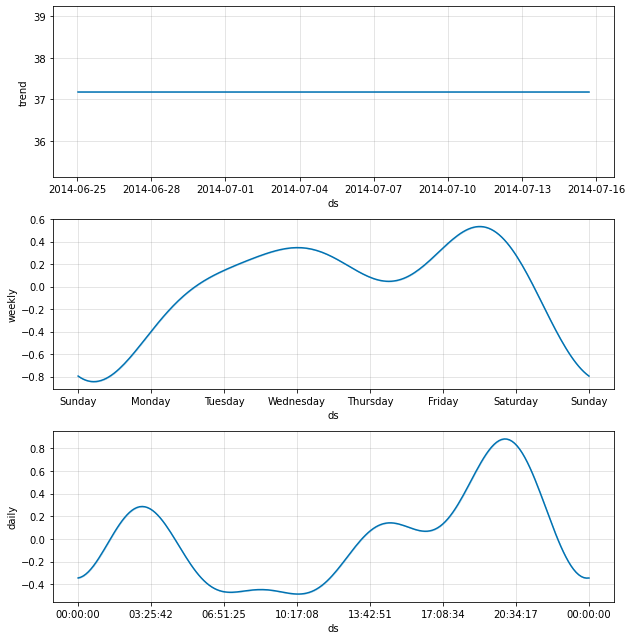

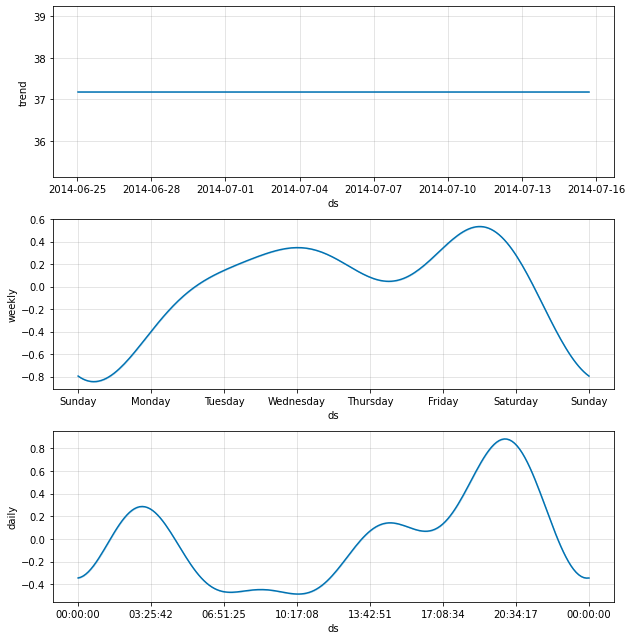

In [ ]:
m.plot_components(preds)